### Mejor modelo de CAE básico hasta el 13/06: Trabaja sobre el dataset de CelebA (reducido a 1000 imagenes)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import zipfile
from skimage.color import lab2rgb
from dataset import CelebADataset
from training import train_model #, load_model
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

## Simple Convolutional Autoencoder (CAE) for 112x112 Images

## With downloaded dataset

### Data Loader

In [3]:
batch_size = 32
# Prepare the Datasets

# Define any additional transformations if needed
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if needed
    # Add other transformations here if needed
])

# Instancia del dataset
image_folder = 'data/celebA/img_celeba'  # Ruta a la carpeta con las imágenes
all_dataset = CelebADataset(image_folder=image_folder, reduced=False, transform=resize_transform)

# Definir las proporciones para entrenamiento, validación y prueba
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1

# Calcular las longitudes de cada conjunto
total_count = len(all_dataset)
train_count = int(total_count * train_ratio)
valid_count = int(total_count * valid_ratio)
test_count = total_count - train_count - valid_count  # Asegura que sumen el total

# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Dividir el dataset
train_dataset, valid_dataset, test_dataset = random_split(all_dataset, [train_count, valid_count, test_count])

# Crear DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Imprimir las longitudes de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Tamaño del conjunto de entrenamiento: 748
Tamaño del conjunto de validación: 149
Tamaño del conjunto de prueba: 101


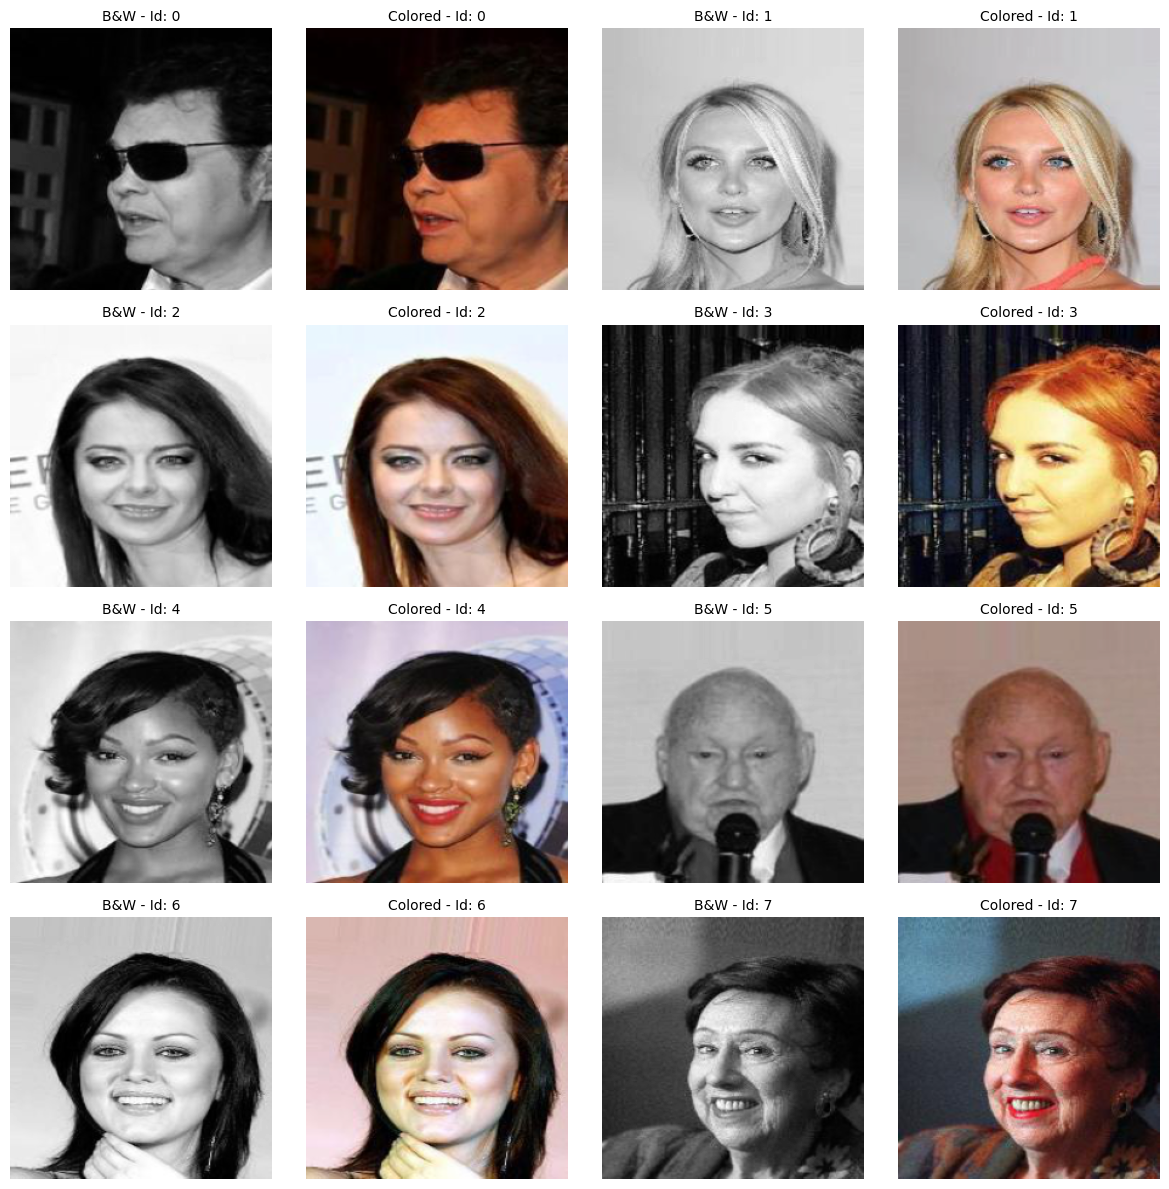

In [5]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)  # Carga un batch del DataLoader

# Configuración del plot
fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4 filas, 4 columnas para 8 pares de imágenes

for i in range(8):  # Solo necesitamos 8 pares de imágenes, total 16 subplots
    row = i // 2  # Cada fila tiene 2 pares
    col = (i % 2) * 2  # Columna alterna para B&W y Colored (0, 2 para B&W; 1, 3 para Colored)

    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(labels[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = ab_image * 128  # Escalar a y b de [-1, 1] a [-128, 127]

    # Imagen en escala de grises
    axs[row, col].imshow(l_image, cmap='gray')
    axs[row, col].set_title(f'B&W - Id: {i}', fontsize=10)
    axs[row, col].axis('off')  # Desactiva los ejes

    # Imagen coloreada
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image  # L canal
    img_lab[:,:,1:] = ab_image.transpose(1, 2, 0)  # a y b canales
    img_rgb = lab2rgb(img_lab)  # Convierte LAB a RGB
    axs[row, col + 1].imshow(img_rgb)
    axs[row, col + 1].set_title(f'Colored - Id: {i}', fontsize=10)
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Define the CAE architecture to colorize images (greyscale to LAB)

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        """
        encoder architecture explained:
        - input: 1x224x224
        - output: 8x28x28

        1. Conv2d: 1 input channel, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x28x28
        - output: 2x224x224
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 2 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re

In [7]:
architecture = CAE()
summary(architecture, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 224, 224]             160
              ReLU-2         [32, 16, 224, 224]               0
         MaxPool2d-3         [32, 16, 112, 112]               0
            Conv2d-4          [32, 8, 112, 112]           1,160
              ReLU-5          [32, 8, 112, 112]               0
         MaxPool2d-6            [32, 8, 56, 56]               0
   ConvTranspose2d-7         [32, 16, 112, 112]           1,168
              ReLU-8         [32, 16, 112, 112]               0
   ConvTranspose2d-9          [32, 2, 224, 224]             290
          Sigmoid-10          [32, 2, 224, 224]               0
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.12
Forward/backward pass size (MB): 643.12
Params size (MB): 0.01
Estimated Tot

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [8]:
architecture = CAE()
file_name = "cae_1.3"
train_model(train_loader, architecture, file_name, epochs=100)

2024-06-14 11:23:15.353896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of parameters: 2778


Epoch 1: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s, loss=0.1581]


Epoch [1/100], Loss: 0.1962


Epoch 2: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s, loss=0.0448]


Epoch [2/100], Loss: 0.0857


Epoch 3: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s, loss=0.0210]


Epoch [3/100], Loss: 0.0264


Epoch 4: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s, loss=0.0249]


Epoch [4/100], Loss: 0.0188


Epoch 5: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s, loss=0.0136]


Epoch [5/100], Loss: 0.0167


Epoch 6: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s, loss=0.0155]


Epoch [6/100], Loss: 0.0159


Epoch 7: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s, loss=0.0160]


Epoch [7/100], Loss: 0.0155


Epoch 8: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s, loss=0.0132]


Epoch [8/100], Loss: 0.0152


Epoch 9: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s, loss=0.0171]


Epoch [9/100], Loss: 0.0151


Epoch 10: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s, loss=0.0143]


Epoch [10/100], Loss: 0.0149


Epoch 11: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s, loss=0.0147]


Epoch [11/100], Loss: 0.0149


Epoch 12: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s, loss=0.0209]


Epoch [12/100], Loss: 0.0150


Epoch 13: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s, loss=0.0162]


Epoch [13/100], Loss: 0.0148


Epoch 14: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s, loss=0.0111]


Epoch [14/100], Loss: 0.0146


Epoch 15: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s, loss=0.0159]


Epoch [15/100], Loss: 0.0147


Epoch 16: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s, loss=0.0125]


Epoch [16/100], Loss: 0.0146


Epoch 17: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s, loss=0.0168]


Epoch [17/100], Loss: 0.0147


Epoch 18: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s, loss=0.0106]


Epoch [18/100], Loss: 0.0146


Epoch 19: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s, loss=0.0201]


Epoch [19/100], Loss: 0.0148


Epoch 20: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s, loss=0.0178]


Epoch [20/100], Loss: 0.0147


Epoch 21: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s, loss=0.0118]


Epoch [21/100], Loss: 0.0146


Epoch 22: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s, loss=0.0116]


Epoch [22/100], Loss: 0.0146


Epoch 23: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s, loss=0.0182]


Epoch [23/100], Loss: 0.0147


Epoch 24: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s, loss=0.0192]


Epoch [24/100], Loss: 0.0147


Epoch 25: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s, loss=0.0147]


Epoch [25/100], Loss: 0.0146


Epoch 26: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s, loss=0.0106]


Epoch [26/100], Loss: 0.0145


Epoch 27: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s, loss=0.0093]


Epoch [27/100], Loss: 0.0145


Epoch 28: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s, loss=0.0143]


Epoch [28/100], Loss: 0.0146


Epoch 29: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s, loss=0.0159]


Epoch [29/100], Loss: 0.0146


Epoch 30: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s, loss=0.0143]


Epoch [30/100], Loss: 0.0146


Epoch 31: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s, loss=0.0112]


Epoch [31/100], Loss: 0.0145


Epoch 32: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s, loss=0.0200]


Epoch [32/100], Loss: 0.0147


Epoch 33: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s, loss=0.0216]


Epoch [33/100], Loss: 0.0147


Epoch 34: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s, loss=0.0082]


Epoch [34/100], Loss: 0.0144


Epoch 35: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s, loss=0.0107]


Epoch [35/100], Loss: 0.0144


Epoch 36: 100%|██████████| 24/24 [00:20<00:00,  1.18it/s, loss=0.0127]


Epoch [36/100], Loss: 0.0144


Epoch 37: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s, loss=0.0143]


Epoch [37/100], Loss: 0.0144


Epoch 38: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s, loss=0.0109]


Epoch [38/100], Loss: 0.0142


Epoch 39: 100%|██████████| 24/24 [00:20<00:00,  1.17it/s, loss=0.0129]


Epoch [39/100], Loss: 0.0141


Epoch 40: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s, loss=0.0094]


Epoch [40/100], Loss: 0.0137


Epoch 41: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s, loss=0.0113]


Epoch [41/100], Loss: 0.0131


Epoch 42: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0124]


Epoch [42/100], Loss: 0.0120


Epoch 43: 100%|██████████| 24/24 [00:19<00:00,  1.20it/s, loss=0.0108]


Epoch [43/100], Loss: 0.0108


Epoch 44: 100%|██████████| 24/24 [00:20<00:00,  1.18it/s, loss=0.0098]


Epoch [44/100], Loss: 0.0099


Epoch 45: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s, loss=0.0067]


Epoch [45/100], Loss: 0.0094


Epoch 46: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s, loss=0.0101]


Epoch [46/100], Loss: 0.0092


Epoch 47: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0144]


Epoch [47/100], Loss: 0.0093


Epoch 48: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0100]


Epoch [48/100], Loss: 0.0091


Epoch 49: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s, loss=0.0093]


Epoch [49/100], Loss: 0.0090


Epoch 50: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0037]


Epoch [50/100], Loss: 0.0088


Epoch 51: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s, loss=0.0092]


Epoch [51/100], Loss: 0.0090


Epoch 52: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0060]


Epoch [52/100], Loss: 0.0089


Epoch 53: 100%|██████████| 24/24 [00:21<00:00,  1.11it/s, loss=0.0072]


Epoch [53/100], Loss: 0.0089


Epoch 54: 100%|██████████| 24/24 [00:21<00:00,  1.13it/s, loss=0.0072]


Epoch [54/100], Loss: 0.0089


Epoch 55: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s, loss=0.0066]


Epoch [55/100], Loss: 0.0088


Epoch 56: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0074]


Epoch [56/100], Loss: 0.0089


Epoch 57: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s, loss=0.0103]


Epoch [57/100], Loss: 0.0089


Epoch 58: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s, loss=0.0091]


Epoch [58/100], Loss: 0.0089


Epoch 59: 100%|██████████| 24/24 [00:21<00:00,  1.13it/s, loss=0.0073]


Epoch [59/100], Loss: 0.0088


Epoch 60: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0049]


Epoch [60/100], Loss: 0.0087


Epoch 61: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0079]


Epoch [61/100], Loss: 0.0088


Epoch 62: 100%|██████████| 24/24 [00:20<00:00,  1.17it/s, loss=0.0077]


Epoch [62/100], Loss: 0.0088


Epoch 63: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0176]


Epoch [63/100], Loss: 0.0090


Epoch 64: 100%|██████████| 24/24 [00:21<00:00,  1.13it/s, loss=0.0105]


Epoch [64/100], Loss: 0.0088


Epoch 65: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s, loss=0.0100]


Epoch [65/100], Loss: 0.0088


Epoch 66: 100%|██████████| 24/24 [00:21<00:00,  1.11it/s, loss=0.0070]


Epoch [66/100], Loss: 0.0088


Epoch 67: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0116]


Epoch [67/100], Loss: 0.0089


Epoch 68: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0097]


Epoch [68/100], Loss: 0.0088


Epoch 69: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s, loss=0.0094]


Epoch [69/100], Loss: 0.0088


Epoch 70: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s, loss=0.0074]


Epoch [70/100], Loss: 0.0087


Epoch 71: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it, loss=0.0085]


Epoch [71/100], Loss: 0.0087


Epoch 72: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it, loss=0.0146]


Epoch [72/100], Loss: 0.0089


Epoch 73: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it, loss=0.0104]


Epoch [73/100], Loss: 0.0088


Epoch 74: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it, loss=0.0062]


Epoch [74/100], Loss: 0.0087


Epoch 75: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it, loss=0.0065]


Epoch [75/100], Loss: 0.0087


Epoch 76: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it, loss=0.0061]


Epoch [76/100], Loss: 0.0087


Epoch 77: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s, loss=0.0110]


Epoch [77/100], Loss: 0.0088


Epoch 78: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0085]


Epoch [78/100], Loss: 0.0087


Epoch 79: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=0.0107]


Epoch [79/100], Loss: 0.0088


Epoch 80: 100%|██████████| 24/24 [00:20<00:00,  1.14it/s, loss=0.0057]


Epoch [80/100], Loss: 0.0086


Epoch 81: 100%|██████████| 24/24 [00:21<00:00,  1.09it/s, loss=0.0049]


Epoch [81/100], Loss: 0.0087


Epoch 82: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s, loss=0.0193]


Epoch [82/100], Loss: 0.0090


Epoch 83: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s, loss=0.0070]


Epoch [83/100], Loss: 0.0087


Epoch 84: 100%|██████████| 24/24 [00:20<00:00,  1.17it/s, loss=0.0084]


Epoch [84/100], Loss: 0.0087


Epoch 85: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s, loss=0.0060]


Epoch [85/100], Loss: 0.0086


Epoch 86: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s, loss=0.0069]


Epoch [86/100], Loss: 0.0086


Epoch 87: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s, loss=0.0127]


Epoch [87/100], Loss: 0.0088


Epoch 88: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s, loss=0.0097]


Epoch [88/100], Loss: 0.0087


Epoch 89: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s, loss=0.0119]


Epoch [89/100], Loss: 0.0088


Epoch 90: 100%|██████████| 24/24 [00:20<00:00,  1.20it/s, loss=0.0084]


Epoch [90/100], Loss: 0.0088


Epoch 91: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s, loss=0.0087]


Epoch [91/100], Loss: 0.0088


Epoch 92: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s, loss=0.0094]


Epoch [92/100], Loss: 0.0087


Epoch 93: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s, loss=0.0060]


Epoch [93/100], Loss: 0.0086


Epoch 94: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s, loss=0.0132]


Epoch [94/100], Loss: 0.0088


Epoch 95: 100%|██████████| 24/24 [00:22<00:00,  1.04it/s, loss=0.0098]


Epoch [95/100], Loss: 0.0087


Epoch 96: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.0066]


Epoch [96/100], Loss: 0.0086


Epoch 97: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s, loss=0.0129]


Epoch [97/100], Loss: 0.0088


Epoch 98: 100%|██████████| 24/24 [00:20<00:00,  1.18it/s, loss=0.0069]


Epoch [98/100], Loss: 0.0086


Epoch 99: 100%|██████████| 24/24 [00:22<00:00,  1.07it/s, loss=0.0074]


Epoch [99/100], Loss: 0.0087


Epoch 100: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.0078]

Epoch [100/100], Loss: 0.0086
Finished Training


In [9]:
# Define transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

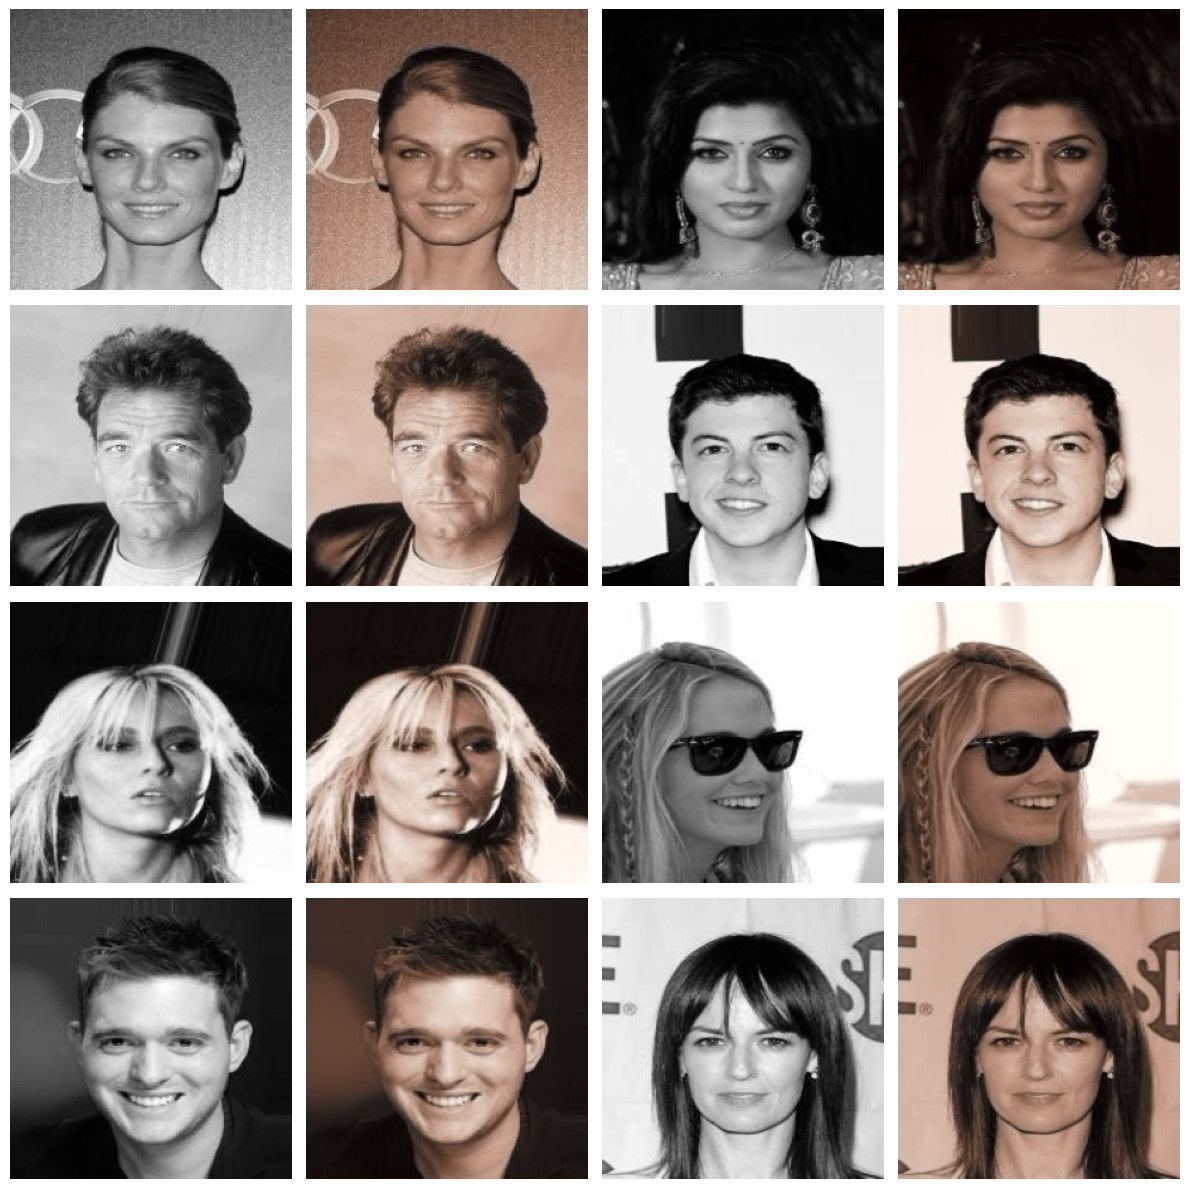

In [14]:
# # Cargar el dataset
# test_dataset = datasets.ImageFolder(root='path/to/your/test/dataset', transform=transform)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('trained_models/cae_1.2_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
outputs = model(images)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    # Imagen en escala de grises
    gray_image = tensor_to_numpy(images[i]).squeeze()
    axs[i//2, (i % 2) * 2].imshow(gray_image, cmap='gray')
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada (predicción)
    ab_image = tensor_to_numpy(outputs[i])
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = gray_image * 100  # L canal
    img_lab[:,:,1:] = (ab_image.transpose(1, 2, 0)) * 127.5  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')
plt.tight_layout()
plt.show()

# Method 2

In [10]:
import os
from pathlib import Path

# Import glob to get the files directories recursively
import glob

# Import Garbage collector interface
import gc 

# Import OpenCV to transforme pictures
import cv2

# Import Time
import time

# import numpy for math calculations
import numpy as np

# Import pandas for data (csv) manipulation
import pandas as pd

# Import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight') 
%matplotlib inline

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import pytorch_lightning as pl

# Import pytorch to build Deel Learling Models 
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

from torchsummary import summary

# Import tqdm to show a smart progress meter
from tqdm import tqdm

In [11]:
def lab_to_rgb(L, ab):
    """
    Takes an image or a batch of images and converts from LAB space to RGB
    """
    L = L * 100  # Escalar L de [0, 1] a [0, 100]
    ab = (ab) * 128  # Escalar a y b de [-1, 1] a [-128, 127]
    Lab = torch.cat([L, ab], dim=1).detach().cpu().numpy()  # Concatenar L y ab, y convertir a numpy
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img.transpose(1, 2, 0))
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

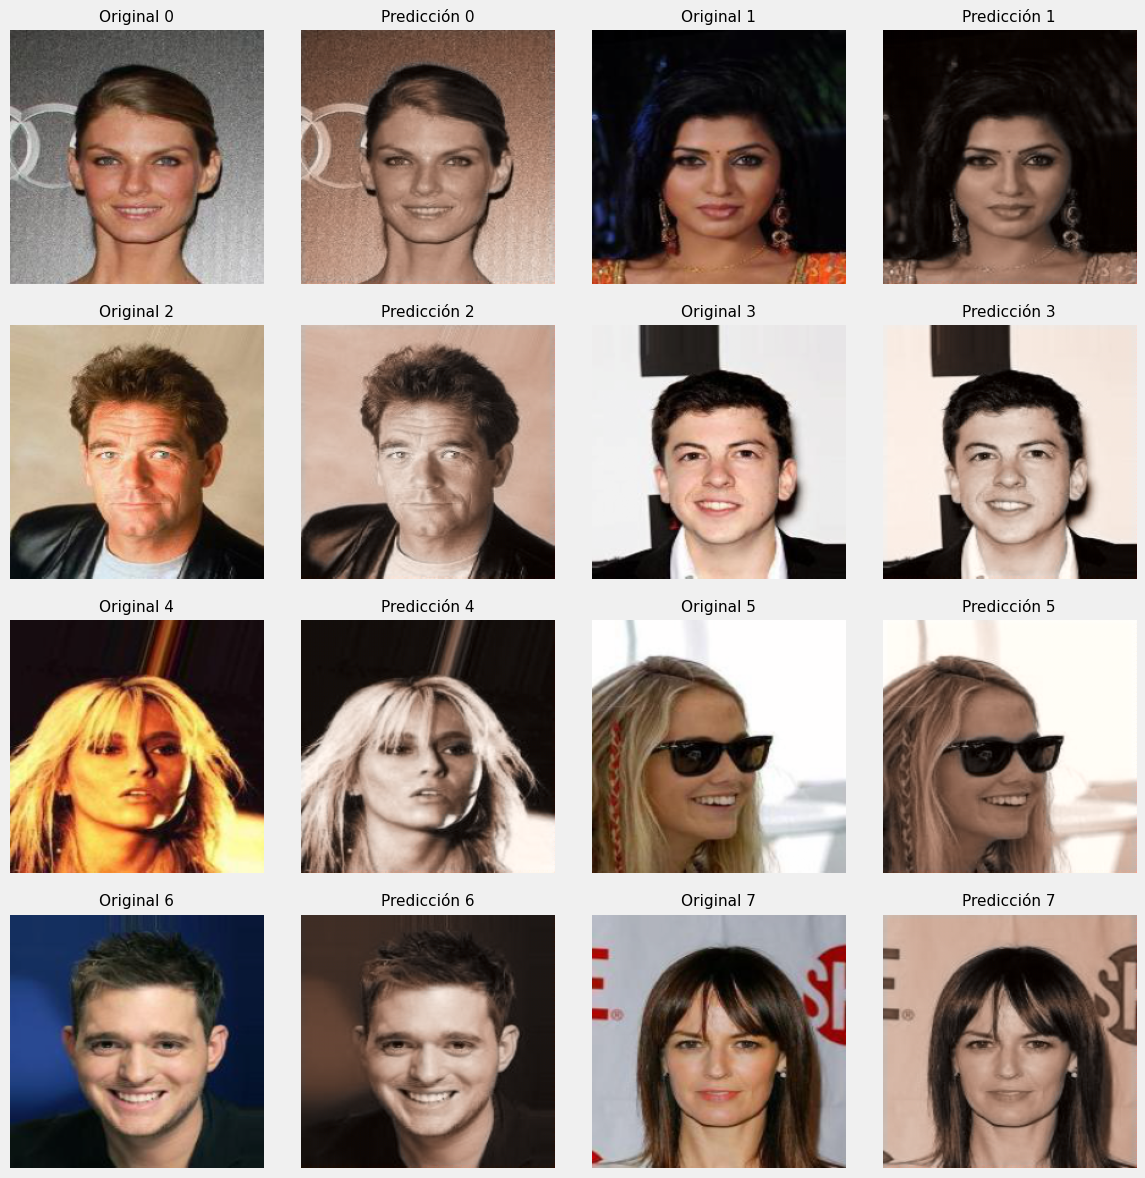

In [13]:
# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('full_models/cae_1.2_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
l_images, ab_images = next(dataiter)
l_images, ab_images = l_images.to(device), ab_images.to(device)
output_ab = model(l_images)

# Convertir imágenes originales y predicciones a RGB
original_rgb = lab_to_rgb(l_images, ab_images)
predicted_rgb = lab_to_rgb(l_images, output_ab)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Imagen en color original
    axs[i//2, (i % 2) * 2].imshow(original_rgb[i])
    axs[i//2, (i % 2) * 2].axis('off')
    axs[i//2, (i % 2) * 2].set_title(f'Original {i}', fontsize=11)
    
    # Imagen colorizada (predicción)
    axs[i//2, (i % 2) * 2 + 1].imshow(predicted_rgb[i])
    axs[i//2, (i % 2) * 2 + 1].axis('off')
    axs[i//2, (i % 2) * 2 + 1].set_title(f'Predicción {i}', fontsize=11)

plt.tight_layout()
plt.show()

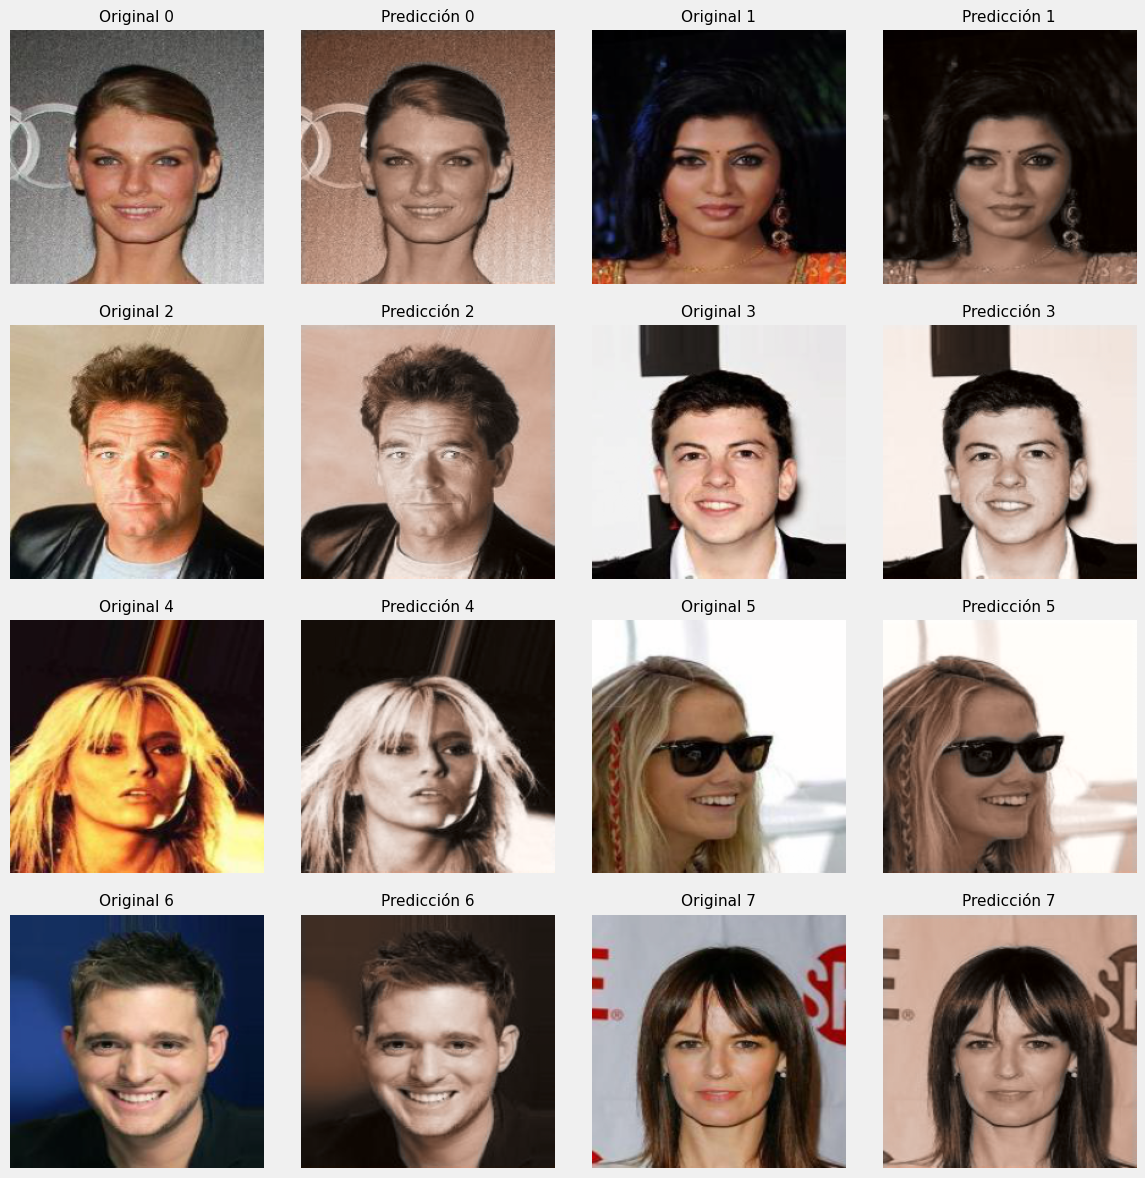

In [14]:
# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('full_models/cae_1.3_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
l_images, ab_images = next(dataiter)
l_images, ab_images = l_images.to(device), ab_images.to(device)
output_ab = model(l_images)

# Convertir imágenes originales y predicciones a RGB
original_rgb = lab_to_rgb(l_images, ab_images)
predicted_rgb = lab_to_rgb(l_images, output_ab)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Imagen en color original
    axs[i//2, (i % 2) * 2].imshow(original_rgb[i])
    axs[i//2, (i % 2) * 2].axis('off')
    axs[i//2, (i % 2) * 2].set_title(f'Original {i}', fontsize=11)
    
    # Imagen colorizada (predicción)
    axs[i//2, (i % 2) * 2 + 1].imshow(predicted_rgb[i])
    axs[i//2, (i % 2) * 2 + 1].axis('off')
    axs[i//2, (i % 2) * 2 + 1].set_title(f'Predicción {i}', fontsize=11)

plt.tight_layout()
plt.show()